# LLM experiments for sentiment analysis

## Import required packages

In [13]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
# Import generic wrappers
from transformers import AutoTokenizer, AutoModelForSequenceClassification 
from tqdm import tqdm
tqdm.pandas()

## Load Abels english dataset and test permormance

In [65]:
data = pd.read_csv('LLM_examples.csv', sep=';')
data.columns = ["sentence", "sentiment"]
data['label'] = data['sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)

In [66]:
data.head()

,sentence,sentiment,label
0,I absolutely loved the new movie; it was fanta...,Positive,2
1,The customer service was excellent; they were ...,Positive,2
2,This is the best product I've ever used; highl...,Positive,2
3,I’m so happy with my recent purchase; it excee...,Positive,2
4,The event was incredibly well-organized and en...,Positive,2


## Test performance of task specific models

In [67]:
# Define the model repo
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" 


# Download pytorch model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/eq81tw/.homebrew/anaconda3/envs/py39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then

In [68]:
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  predicted_class = int(torch.argmax(result.logits))
  class_probabilities = softmax(result[0][0].detach().numpy())
  positive_probability = class_probabilities[2]/(class_probabilities[2] + class_probabilities[0])
  return positive_probability

In [69]:
data['positive_probability'] = data['sentence'].progress_apply(lambda x: sentiment_score(x[:512]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:42<00:00, 24.10it/s]


In [145]:
def discretise_probability(probability):
    if probability <= 0.04:
        return 0
    elif probability <= 0.994:
        return 1
    else:
        return 2

In [146]:
q1 = data['positive_probability'].quantile(0.25)
q3 = data['positive_probability'].quantile(0.75)
print(q1, q3)

0.014705522218719125 0.9960869252681732


array([[<Axes: title={'center': 'positive_probability'}>]], dtype=object)

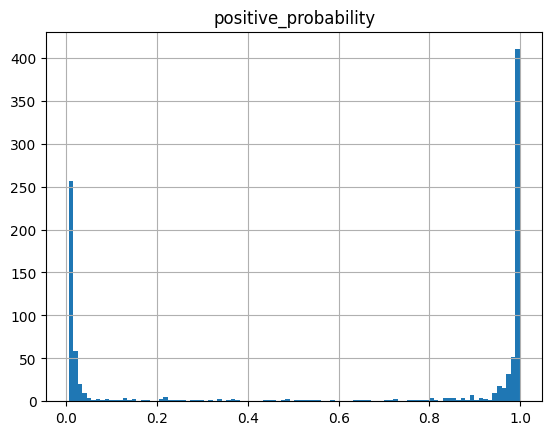

In [147]:
data[['positive_probability']].hist(bins=100)

In [148]:
data['predicted_label'] = data['positive_probability'].apply(lambda x: discretise_probability(x))

In [149]:
data.sort_values(by="positive_probability", ascending=False)

,sentence,sentiment,label,positive_probability,predicted_label
210,I received an invitation to speak at a confere...,Positive,2,0.998496,2
542,The weather was perfect for a bike ride around...,Positive,2,0.998284,2
562,"Went stargazing tonight, and the sky was so cl...",Positive,2,0.998283,2
730,Got a surprise package in the mail today from ...,Positive,2,0.998215,2
305,"The local bakery introduced a new flavor, and ...",Positive,2,0.998193,2
...,...,...,...,...,...
47,The new apartment has too many issues; I regre...,Negative,0,0.005290,0
852,The movie I rented was really bad—total waste ...,Negative,0,0.005076,0
745,"My flight got delayed, and now I’m stuck at th...",Negative,0,0.004990,0
151,The traffic was so bad that it took me twice a...,Negative,0,0.004980,0


In [150]:
#chech performance
from sklearn import metrics

# define confusion matrix
confusion_matrix = metrics.confusion_matrix(data['label'], data['predicted_label'])

print(confusion_matrix)

[[330  10   0]
 [ 12 299  29]
 [  0  19 321]]


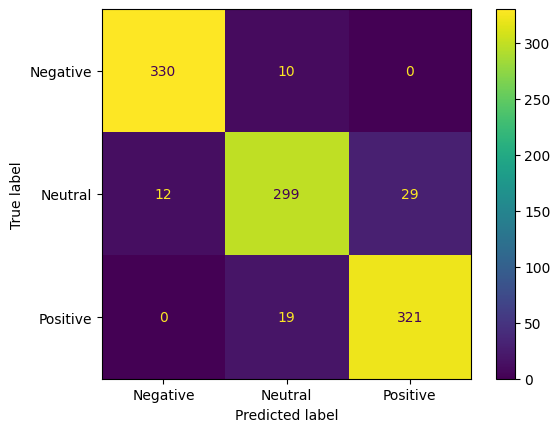

In [151]:
# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

In [158]:
data = data.sort_values(by="positive_probability", ascending=True)
data.head()

,sentence,sentiment,label,positive_probability,predicted_label
863,"My flight was delayed, and now I’m stuck at th...",Negative,0,0.004937,0
151,The traffic was so bad that it took me twice a...,Negative,0,0.004980,0
745,"My flight got delayed, and now I’m stuck at th...",Negative,0,0.004990,0
852,The movie I rented was really bad—total waste ...,Negative,0,0.005076,0
47,The new apartment has too many issues; I regre...,Negative,0,0.005290,0


In [159]:
metrics.auc(data['positive_probability'], data['label'])

np.float64(0.8953780070878565)

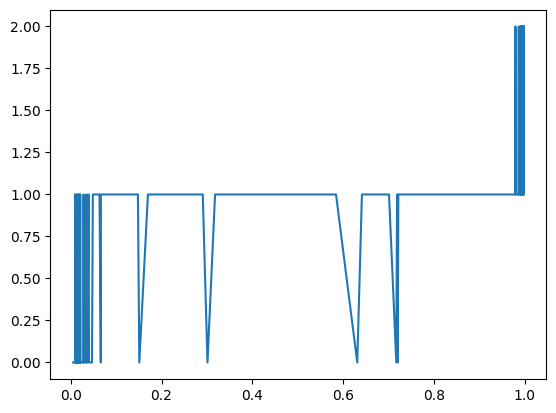

In [160]:
plt.plot(data['positive_probability'], data['label'])